# Upwork Job Postings

# 📊 Analyzing the Most In-Demand Skills Across Different Job Categories

## 📝 Project Overview

In this notebook, we analyze job descriptions to uncover the most in-demand skills across various job categories. The main goal is to group similar job descriptions into clusters and extract the most frequent and representative skills in each cluster. This helps in understanding which skill sets are dominant in the market and can guide freelancers, job seekers, and training providers in aligning with job market needs.


## 📦 Import Libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans , AgglomerativeClustering , DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from scipy.cluster.hierarchy import dendrogram , linkage
from sklearn.utils import resample
from kneed import KneeLocator

In [2]:
pio.templates.default = 'plotly_dark'

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\youse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\youse\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Read the Dataset

In [4]:
df = pd.read_csv('upwork-jobs.csv')
df

title  \
0      Experienced Media Buyer For Solar Pannel and R...   
1                                   Full Stack Developer   
2                                        SMMA Bubble App   
3                 Talent Hunter Specialized in Marketing   
4                                          Data Engineer   
...                                                  ...   
53053        Partial Migration From WordPress to Shopify   
53054              Logo work &amp; Event Booth Rendering   
53055              Wedding Dress Collection Photographer   
53056                           Design a startup profile   
53057  Make room and price modifications to Hotel boo...   

                                                    link  \
0      https://www.upwork.com/jobs/Experienced-Media-...   
1      https://www.upwork.com/jobs/Full-Stack-Develop...   
2      https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3      https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4      https://www.upwork.com/jobs/Data-Engineer_%7E0...   
...                                                  ...   
53053  https://www.upwork.com/jobs/Partial-Migration-...   
53054  https://www.upwork.com/jobs/Logo-work-amp-Even...   
53055  https://www.upwork.com/jobs/Wedding-Dress-Coll...   
53056  https://www.upwork.com/jobs/Design-startup-pro...   
53057  https://www.upwork.com/jobs/Make-room-and-pric...   

                                             description  \
0      We’re looking for a talented and hardworking a...   
1      Job Title: Full Stack DeveloperWe are seeking ...   
2      I need someone to redesign my bubble.io site t...   
3      Join Our Growing Team!We are an innovative com...   
4      We are looking for a resource who can work par...   
...                                                  ...   
53053  We're moving from Wordpress to Shopify. The Sh...   
53054  I need some art works rendered in to booth des...   
53055  We are looking for a skilled photographer to c...   
53056  I building a startup company and I want to des...   
53057  Ok the functionality of the site works fine We...   

                  published_date is_hourly  hourly_low  hourly_high  budget  \
0      2024-02-17 09:09:54+00:00     False         NaN          NaN   500.0   
1      2024-02-17 09:09:17+00:00     False         NaN          NaN  1100.0   
2      2024-02-17 09:08:46+00:00      True        10.0         30.0     NaN   
3      2024-02-17 09:08:08+00:00       NaN         NaN          NaN     NaN   
4      2024-02-17 09:07:42+00:00     False         NaN          NaN   650.0   
...                          ...       ...         ...          ...     ...   
53053  2024-02-14 06:40:39+00:00     False         NaN          NaN   150.0   
53054  2024-02-14 06:40:26+00:00     False         NaN          NaN    30.0   
53055  2024-02-14 06:40:06+00:00      True        23.0         51.0     NaN   
53056  2024-02-14 06:40:06+00:00     False         NaN          NaN    70.0   
53057  2024-02-17 03:12:29+00:00     False         NaN          NaN    60.0   

             country  
0                NaN  
1      United States  
2      United States  
3      United States  
4              India  
...              ...  
53053      Australia  
53054  United States  
53055      Australia  
53056   Saudi Arabia  
53057  United States  

[53058 rows x 9 columns]

## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53058 entries, 0 to 53057
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           53058 non-null  object 
 1   link            53058 non-null  object 
 2   description     53058 non-null  object 
 3   published_date  53058 non-null  object 
 4   is_hourly       44829 non-null  object 
 5   hourly_low      22956 non-null  float64
 6   hourly_high     22161 non-null  float64
 7   budget          21873 non-null  float64
 8   country         51917 non-null  object 
dtypes: float64(3), object(6)
memory usage: 3.6+ MB


In [6]:
df.describe()

hourly_low   hourly_high          budget
count  22956.000000  22161.000000    21873.000000
mean      17.467895     41.608050      746.263521
std       18.228234     47.968562    10639.241140
min        3.000000      3.000000        5.000000
25%        8.000000     20.000000       30.000000
50%       15.000000     30.000000      100.000000
75%       20.000000     50.000000      300.000000
max      500.000000    999.000000  1000000.000000

## 📝 Copying the Original Data


In [7]:
df_WV = df.copy()

### Drop unnecessary columns that do not contribute in this problem to reduce dimensionality of columns

In [8]:
df_WV.drop(['title', 'link', 'published_date', 'is_hourly',
       'hourly_low', 'hourly_high', 'budget', 'country'] , axis=1 , inplace=True)

In [9]:
df_WV

description
0      We’re looking for a talented and hardworking a...
1      Job Title: Full Stack DeveloperWe are seeking ...
2      I need someone to redesign my bubble.io site t...
3      Join Our Growing Team!We are an innovative com...
4      We are looking for a resource who can work par...
...                                                  ...
53053  We're moving from Wordpress to Shopify. The Sh...
53054  I need some art works rendered in to booth des...
53055  We are looking for a skilled photographer to c...
53056  I building a startup company and I want to des...
53057  Ok the functionality of the site works fine We...

[53058 rows x 1 columns]

## Text Preprocessing Function

Defines a function `preprocess` that performs basic text cleaning:
- Converts text to lowercase.
- Removes punctuation and digits.
- Tokenizes the text by splitting into words.
- Removes English stopwords.

The function returns a list of clean tokens ready for further analysis or modeling.

In [10]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [11]:
df_WV['tokens'] = df_WV['description'].apply(preprocess)

In [12]:
df_WV.drop(['description'] ,axis=1 , inplace=True)

In [13]:
df_WV

tokens
0      [looking, talented, hardworking, ads, manager,...
1      [job, title, full, stack, developerwe, seeking...
2      [need, someone, redesign, bubbleio, site, opti...
3      [join, growing, teamwe, innovative, company, e...
4      [looking, resource, work, parttime, one, proje...
...                                                  ...
53053  [moving, wordpress, shopify, shopify, built, p...
53054  [need, art, works, rendered, booth, designs, u...
53055  [looking, skilled, photographer, capture, esse...
53056  [building, startup, company, want, design, pro...
53057  [ok, functionality, site, works, fine, need, m...

[53058 rows x 1 columns]

In [14]:
df_WV['tokens'][0]

['looking',
 'talented',
 'hardworking',
 'ads',
 'manager',
 'work',
 'us',
 'deliver',
 'consistent',
 'high',
 'quality',
 'results',
 'clients',
 'ads',
 'manager',
 'work',
 'us',
 'per',
 'clientmonthly',
 'basis',
 'responsible',
 'following',
 'tasks',
 'setting',
 'launching',
 'various',
 'ad',
 'campaigns',
 'setting',
 'retargeting',
 'pixels',
 'custom',
 'conversions',
 'etc',
 'daily',
 'management',
 'advertisement',
 'campaigns',
 'go',
 'live',
 'build',
 'amp',
 'ab',
 'test',
 'highconverting',
 'landing',
 'pagesfunnels',
 'provide',
 'data',
 'generated',
 'leadswell',
 'interviewing',
 'candidates',
 'zoomgoogle',
 'meet',
 'wish',
 'bestbudget',
 'posted',
 'february',
 'utccategory',
 'social',
 'media',
 'marketingskillsfacebook',
 'advertising',
 'social',
 'media',
 'advertising',
 'google',
 'analytics',
 'facebook',
 'ads',
 'manager',
 'google',
 'ads',
 'instagram',
 'marketing',
 'strategy',
 'facebook',
 'search',
 'engine',
 'optimization',
 'social',

#### length of the first list of words

In [15]:
len(df_WV['tokens'][0])

107

## Train Word2Vec Model

Trains a Word2Vec model using the preprocessed tokens from the dataset:
- `sentences`: List of tokenized job descriptions.
- `vector_size=100`: Each word is represented by a 100-dimensional vector.
- `window=5`: Context window size for surrounding words.
- `min_count=2`: Ignores words that appear less than 2 times.
- `workers=4`: Uses 4 CPU cores for training.

This model captures the semantic meaning of words based on their context.

In [16]:
model_w2v = Word2Vec(sentences=df_WV['tokens'], vector_size=100, window=5, min_count=2, workers=4)

In [17]:
type(model_w2v)

gensim.models.word2vec.Word2Vec

## Convert Tokens to Vectors Using Word2Vec

In [18]:
def get_vector(tokens, model):
    valid_tokens = [word for word in tokens if word in model.wv]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

X_w2v = np.array([get_vector(tokens, model_w2v) for tokens in df_WV['tokens']])

#### Shape of the final result 

In [19]:
X_w2v.shape

(53058, 100)

## Applying `PCA` to can see the structure of the data and variation of data point that the words are described

In [20]:
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(X_w2v) , columns=['col1' , 'col2'])

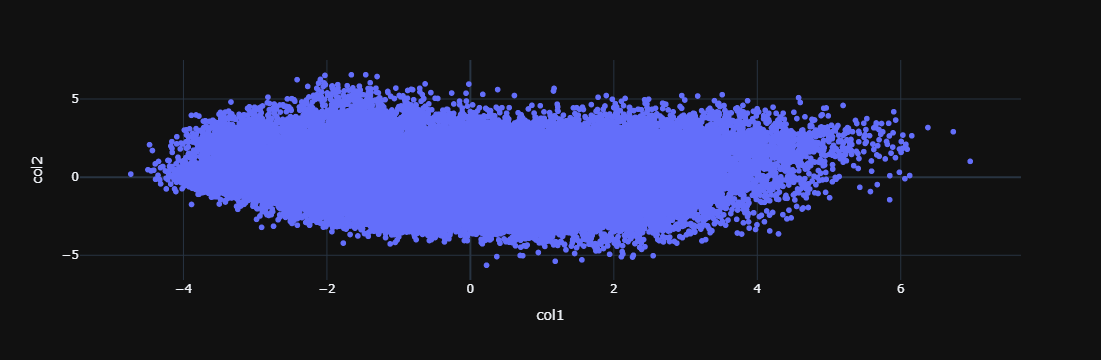

In [21]:
px.scatter(data_frame=df_pca , x = 'col1' , y = 'col2')

#### reduce the dimensionality of the  data set in two columns

In [22]:
df_pca

col1      col2
0     -2.406245  2.501227
1     -1.190678 -2.934434
2      2.644803 -1.602407
3     -2.886454 -0.058160
4     -2.181813 -2.345611
...         ...       ...
53053  0.833158 -1.149133
53054  5.132712  2.264136
53055 -0.660473  1.380392
53056  2.724536  2.226020
53057  0.423895 -1.068399

[53058 rows x 2 columns]

## Applying Unsupervised Clustering Models

Now it's time to apply unsupervised clustering algorithms. We will use **K-Means**, **Agglomerative Clustering**, and **DBSCAN** to cluster the data. 

By comparing their results, we aim to select the best model that provides the most efficient and meaningful number of clusters for our dataset.


### Now, that is the time to find the best number of `clusters` that represent the underlying structure of the data.
- **WCSS** measures how tightly grouped the data points are within each cluster. Lower values indicate more compact clusters.
- **Silhouette Score** evaluates how well-separated the clusters are, with higher values (up to 1) indicating better-defined clusters.

## (1). Kmean 

In [23]:
wcss , score = [] , []
for k in range(2 , 15):
    k_model = KMeans(n_clusters=k)
    y = k_model.fit_predict(df_pca)
    wcss.append(k_model.inertia_)
    score.append(silhouette_score(df_pca , y))

C:\Users\youse\anaconda3\envs\gns\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\youse\anaconda3\envs\gns\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\youse\anaconda3\envs\gns\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\youse\anaconda3\envs\gns\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\youse\anaconda3\envs\gns\lib\site-packages\sklearn\cluster\_kmeans.py:8

### Plot WCSS vs. number of clusters to identify the optimal cluster count using the elbow method.

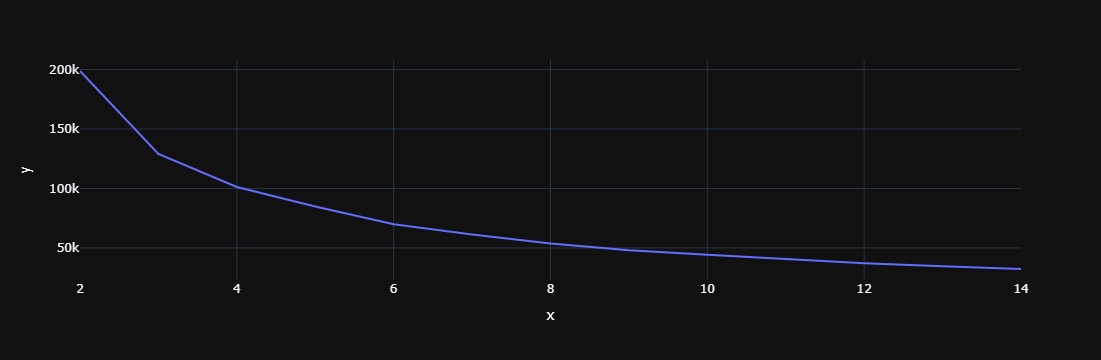

In [24]:
px.line(x = range(2 , 15) , y = wcss)

### find the best number of `Cluster` that the `WSCC` is choice

In [25]:
x = KneeLocator(x = range(2 , 15) , y = wcss , curve='convex' , direction='decreasing').elbow

In [26]:
print(x)

6


### Plot Silhouette Scores against cluster counts to evaluate cluster quality and find the best number of clusters.
- The best number is the highest point in the plot 

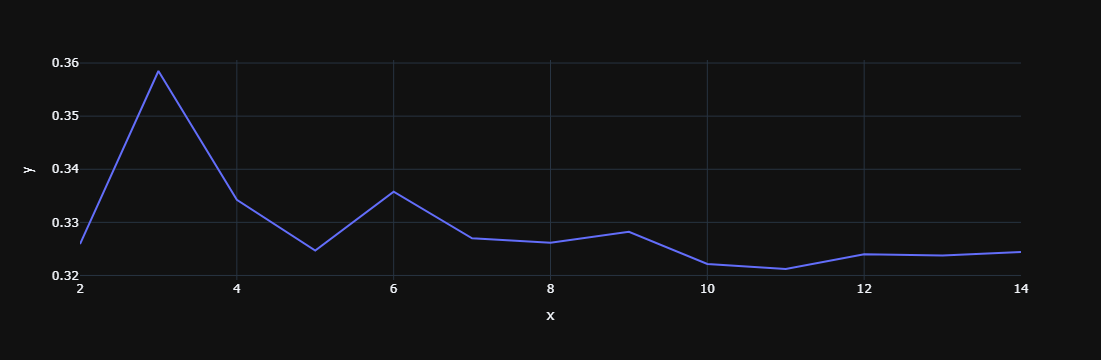

In [27]:
px.line(x= range(2 , 15) , y = score)

#### Apply K-Means clustering with 3 clusters and assign cluster labels to the PCA dataset to plot the graph and show the divid cluster in the data.

In [28]:
kmean_model = KMeans(n_clusters=3)
df_pca['Kmean_C3'] = kmean_model.fit_predict(df_pca)

C:\Users\youse\anaconda3\envs\gns\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Plot the Graph and color by Kmean_C3

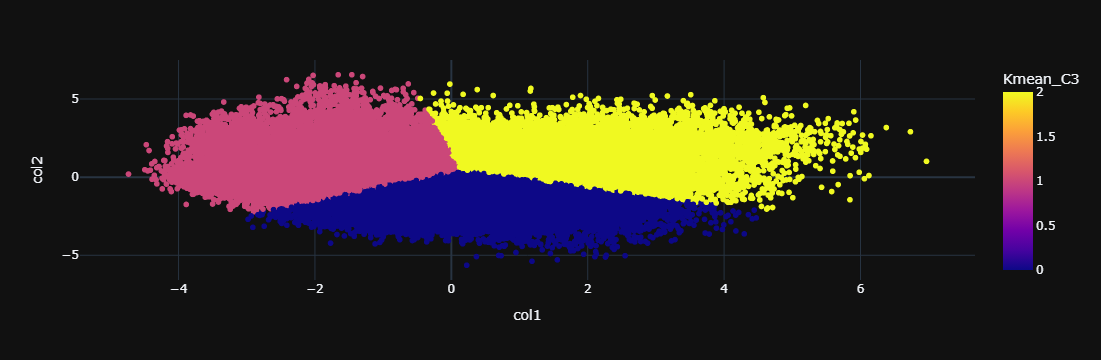

In [29]:
px.scatter(data_frame=df_pca , x = 'col1' , y = 'col2' , color='Kmean_C3')

#### Drop this column to apply Agglomerative model

In [30]:
df_pca.drop(['Kmean_C3'] , axis=1 , inplace=True)

## (2). Agglomerative 

#### Take a sample from PCA data because the Agglomerative can not work in all this data

In [31]:
sample_data = resample(df_pca, n_samples=25000)

#### Show the shape of the data

In [32]:
sample_data.shape

(25000, 2)

### Apply `Silhouette Score` to this model and find the best number of clusters

In [33]:
score = []
for k in range(2 , 15):
    agg_model = AgglomerativeClustering(n_clusters=k)
    y = agg_model.fit_predict(sample_data)
    score.append(silhouette_score(sample_data , y))

### Plot Silhouette Scores against cluster counts to evaluate cluster quality and find the best number of clusters.
- The best number is the highest point in the plot 

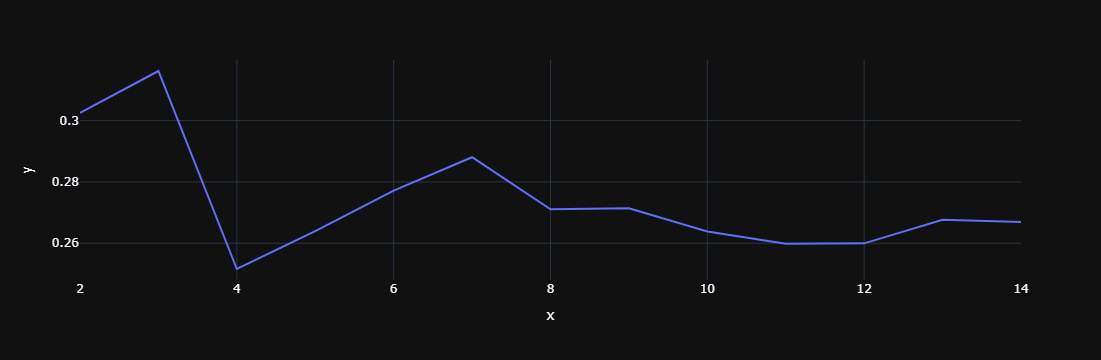

In [34]:
px.line(x = range(2 , 15) , y = score)

#### Apply Agglomerative clustering with 3 clusters and assign cluster labels to the PCA dataset to plot the graph and show the divid cluster in the data.

In [35]:
Agg_model = AgglomerativeClustering(n_clusters=3)
sample_data['Agg_C3'] = Agg_model.fit_predict(sample_data)

### Plot the Graph and color by Agg_C2

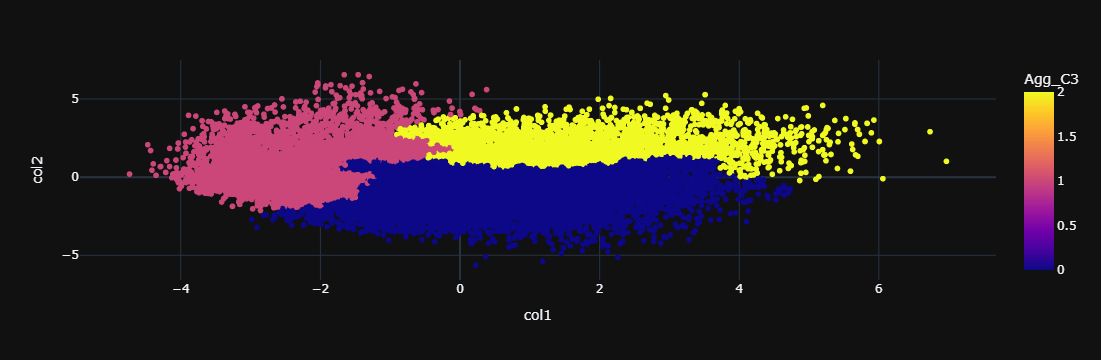

In [36]:
px.scatter(data_frame=sample_data , x = 'col1' , y = 'col2' , color='Agg_C3')

### Apply dendrogram to show the best number of cluster

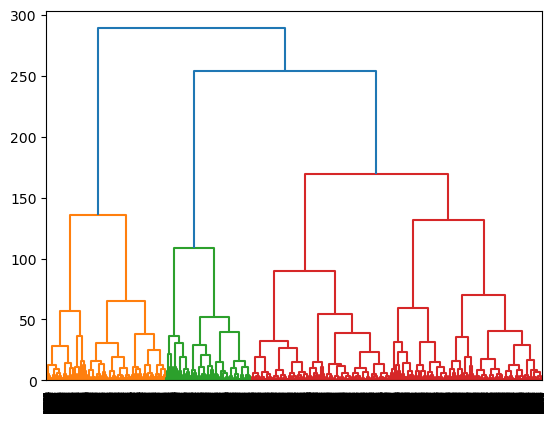

In [37]:
x = dendrogram( linkage( sample_data[sample_data.columns[:-1]] , method='ward'))

## (3). DBSCAN

In [38]:
ds = DBSCAN(eps=0.5 , min_samples=5)
np.unique(ds.fit_predict(df_pca))

array([-1,  0], dtype=int64)

### Test DBSCAN with different `eps` and `min_samples` values to evaluate cluster count and noise points.

In [40]:
for eps in [0.5, 0.7, 1.0, 1.2, 1.5]:
    for min_samples in [3, 5, 10]:
        ds = DBSCAN(eps=eps, min_samples=min_samples)
        labels = ds.fit_predict(df_pca)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        print(f"eps={eps}, min_samples={min_samples} -> Clusters: {n_clusters}, Noise points: {n_noise}")


eps=0.5, min_samples=3 -> Clusters: 2, Noise points: 10
eps=0.5, min_samples=5 -> Clusters: 1, Noise points: 16
eps=0.5, min_samples=10 -> Clusters: 1, Noise points: 28
eps=0.7, min_samples=3 -> Clusters: 1, Noise points: 1
eps=0.7, min_samples=5 -> Clusters: 1, Noise points: 2
eps=0.7, min_samples=10 -> Clusters: 1, Noise points: 6
eps=1.0, min_samples=3 -> Clusters: 1, Noise points: 1
eps=1.0, min_samples=5 -> Clusters: 1, Noise points: 1
eps=1.0, min_samples=10 -> Clusters: 1, Noise points: 1
eps=1.2, min_samples=3 -> Clusters: 1, Noise points: 0
eps=1.2, min_samples=5 -> Clusters: 1, Noise points: 0
eps=1.2, min_samples=10 -> Clusters: 1, Noise points: 0
eps=1.5, min_samples=3 -> Clusters: 1, Noise points: 0
eps=1.5, min_samples=5 -> Clusters: 1, Noise points: 0
eps=1.5, min_samples=10 -> Clusters: 1, Noise points: 0


### Apply `DBSCAN` wiht the best number of cluster with `Epsilon` & `Min-points`

In [41]:
ds = DBSCAN(eps=0.5 , min_samples=3)
print(f"The best number of clusters that DBSCAN choice are :{ len(np.unique(ds.fit_predict(df_pca)))}")
df_pca['DS_C3'] = ds.fit_predict(df_pca)

The best number of clusters that DBSCAN choice are :3


### Plot the Graph and color by DS_C3

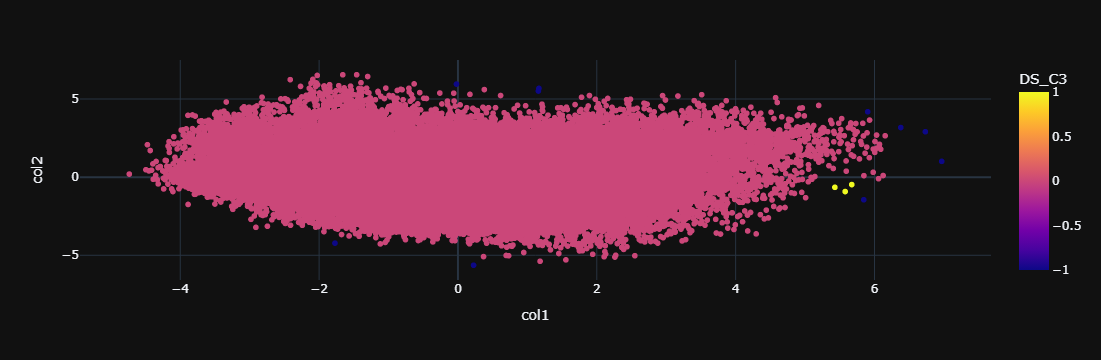

In [42]:
px.scatter(data_frame=df_pca , x = 'col1' , y = 'col2' , color='DS_C3')

In [43]:
df_pca.drop(['DS_C3'] , axis=1 , inplace=True)

## from the previous of applying 3 models of unsupervised the best one is the `KMean Clustering` so, we will apply this model

In [44]:
kmean_model = KMeans(n_clusters=3)
df_pca['Kmean_C3'] = kmean_model.fit_predict(df_pca)

C:\Users\youse\anaconda3\envs\gns\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



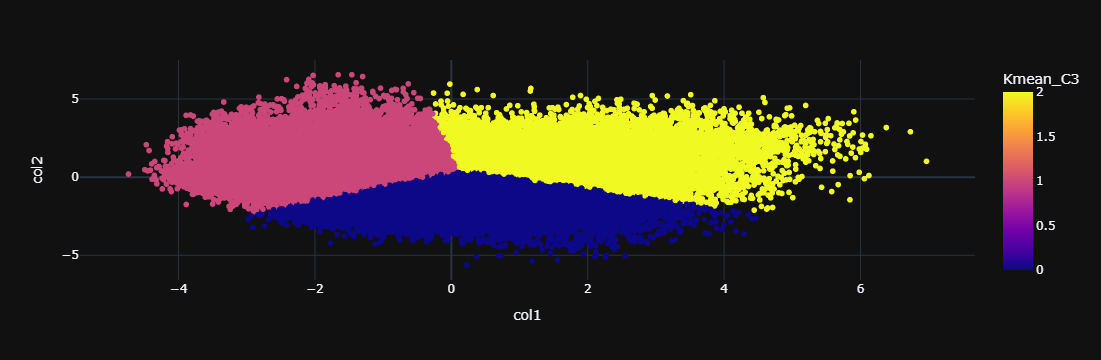

In [45]:
px.scatter(data_frame=df_pca , x = 'col1' , y = 'col2' , color='Kmean_C3')

In [46]:
df['tokens'] = df_WV['tokens']
df['Kmean_cluster'] = df_pca['Kmean_C3']

In [47]:
df

title  \
0      Experienced Media Buyer For Solar Pannel and R...   
1                                   Full Stack Developer   
2                                        SMMA Bubble App   
3                 Talent Hunter Specialized in Marketing   
4                                          Data Engineer   
...                                                  ...   
53053        Partial Migration From WordPress to Shopify   
53054              Logo work &amp; Event Booth Rendering   
53055              Wedding Dress Collection Photographer   
53056                           Design a startup profile   
53057  Make room and price modifications to Hotel boo...   

                                                    link  \
0      https://www.upwork.com/jobs/Experienced-Media-...   
1      https://www.upwork.com/jobs/Full-Stack-Develop...   
2      https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3      https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4      https://www.upwork.com/jobs/Data-Engineer_%7E0...   
...                                                  ...   
53053  https://www.upwork.com/jobs/Partial-Migration-...   
53054  https://www.upwork.com/jobs/Logo-work-amp-Even...   
53055  https://www.upwork.com/jobs/Wedding-Dress-Coll...   
53056  https://www.upwork.com/jobs/Design-startup-pro...   
53057  https://www.upwork.com/jobs/Make-room-and-pric...   

                                             description  \
0      We’re looking for a talented and hardworking a...   
1      Job Title: Full Stack DeveloperWe are seeking ...   
2      I need someone to redesign my bubble.io site t...   
3      Join Our Growing Team!We are an innovative com...   
4      We are looking for a resource who can work par...   
...                                                  ...   
53053  We're moving from Wordpress to Shopify. The Sh...   
53054  I need some art works rendered in to booth des...   
53055  We are looking for a skilled photographer to c...   
53056  I building a startup company and I want to des...   
53057  Ok the functionality of the site works fine We...   

                  published_date is_hourly  hourly_low  hourly_high  budget  \
0      2024-02-17 09:09:54+00:00     False         NaN          NaN   500.0   
1      2024-02-17 09:09:17+00:00     False         NaN          NaN  1100.0   
2      2024-02-17 09:08:46+00:00      True        10.0         30.0     NaN   
3      2024-02-17 09:08:08+00:00       NaN         NaN          NaN     NaN   
4      2024-02-17 09:07:42+00:00     False         NaN          NaN   650.0   
...                          ...       ...         ...          ...     ...   
53053  2024-02-14 06:40:39+00:00     False         NaN          NaN   150.0   
53054  2024-02-14 06:40:26+00:00     False         NaN          NaN    30.0   
53055  2024-02-14 06:40:06+00:00      True        23.0         51.0     NaN   
53056  2024-02-14 06:40:06+00:00     False         NaN          NaN    70.0   
53057  2024-02-17 03:12:29+00:00     False         NaN          NaN    60.0   

             country                                             tokens  \
0                NaN  [looking, talented, hardworking, ads, manager,...   
1      United States  [job, title, full, stack, developerwe, seeking...   
2      United States  [need, someone, redesign, bubbleio, site, opti...   
3      United States  [join, growing, teamwe, innovative, company, e...   
4              India  [looking, resource, work, parttime, one, proje...   
...              ...                                                ...   
53053      Australia  [moving, wordpress, shopify, shopify, built, p...   
53054  United States  [need, art, works, rendered, booth, designs, u...   
53055      Australia  [looking, skilled, photographer, capture, esse...   
53056   Saudi Arabia  [building, startup, company, want, design, pro...   
53057  United States  [ok, functionality, site, works, fine, need, m...   

       Kmean_cluster  
0              

### Extracting Top Words per Cluster

This code identifies the top 15 most frequent words (tokens) in each KMeans cluster of job descriptions. Here's what it does:


In [48]:
from collections import Counter

top_words_per_cluster = {}

for i in range(df['Kmean_cluster'].nunique()):
    all_words = []
    
    cluster_data = df[df['Kmean_cluster'] == i]['tokens']
    for tokens in cluster_data:
        all_words.extend(tokens)

    top_words = Counter(all_words).most_common(15)
    top_words_per_cluster[i] = top_words
    print(f"\nCluster {i} Top Words:")
    print(top_words)



Cluster 0 Top Words:
[('apply', 23058), ('february', 21735), ('utccategory', 21604), ('posted', 18536), ('web', 18290), ('development', 16978), ('data', 16658), ('design', 15030), ('united', 12511), ('need', 12190), ('app', 10671), ('experience', 10065), ('website', 9667), ('looking', 9593), ('range', 9442)]

Cluster 1 Top Words:
[('marketing', 27512), ('media', 25686), ('social', 23574), ('content', 22537), ('apply', 20193), ('february', 17853), ('utccategory', 17801), ('writing', 14811), ('posted', 14554), ('management', 14207), ('experience', 14084), ('skills', 14082), ('work', 12563), ('data', 12548), ('seo', 11792)]

Cluster 2 Top Words:
[('design', 27249), ('video', 16922), ('adobe', 15054), ('apply', 14317), ('february', 13734), ('utccategory', 13653), ('graphic', 13281), ('posted', 12091), ('united', 8380), ('need', 7542), ('editing', 7285), ('logo', 6592), ('web', 6583), ('looking', 6432), ('statesclick', 5713)]


In [49]:
jobs_name = {
    0:'Web & Data Development',
    1:'Digital Marketing & Content',
    2:'Graphic & Video Design'
}

In [50]:
df['jobs'] = df['Kmean_cluster'].map(jobs_name)

In [51]:
df

title  \
0      Experienced Media Buyer For Solar Pannel and R...   
1                                   Full Stack Developer   
2                                        SMMA Bubble App   
3                 Talent Hunter Specialized in Marketing   
4                                          Data Engineer   
...                                                  ...   
53053        Partial Migration From WordPress to Shopify   
53054              Logo work &amp; Event Booth Rendering   
53055              Wedding Dress Collection Photographer   
53056                           Design a startup profile   
53057  Make room and price modifications to Hotel boo...   

                                                    link  \
0      https://www.upwork.com/jobs/Experienced-Media-...   
1      https://www.upwork.com/jobs/Full-Stack-Develop...   
2      https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3      https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4      https://www.upwork.com/jobs/Data-Engineer_%7E0...   
...                                                  ...   
53053  https://www.upwork.com/jobs/Partial-Migration-...   
53054  https://www.upwork.com/jobs/Logo-work-amp-Even...   
53055  https://www.upwork.com/jobs/Wedding-Dress-Coll...   
53056  https://www.upwork.com/jobs/Design-startup-pro...   
53057  https://www.upwork.com/jobs/Make-room-and-pric...   

                                             description  \
0      We’re looking for a talented and hardworking a...   
1      Job Title: Full Stack DeveloperWe are seeking ...   
2      I need someone to redesign my bubble.io site t...   
3      Join Our Growing Team!We are an innovative com...   
4      We are looking for a resource who can work par...   
...                                                  ...   
53053  We're moving from Wordpress to Shopify. The Sh...   
53054  I need some art works rendered in to booth des...   
53055  We are looking for a skilled photographer to c...   
53056  I building a startup company and I want to des...   
53057  Ok the functionality of the site works fine We...   

                  published_date is_hourly  hourly_low  hourly_high  budget  \
0      2024-02-17 09:09:54+00:00     False         NaN          NaN   500.0   
1      2024-02-17 09:09:17+00:00     False         NaN          NaN  1100.0   
2      2024-02-17 09:08:46+00:00      True        10.0         30.0     NaN   
3      2024-02-17 09:08:08+00:00       NaN         NaN          NaN     NaN   
4      2024-02-17 09:07:42+00:00     False         NaN          NaN   650.0   
...                          ...       ...         ...          ...     ...   
53053  2024-02-14 06:40:39+00:00     False         NaN          NaN   150.0   
53054  2024-02-14 06:40:26+00:00     False         NaN          NaN    30.0   
53055  2024-02-14 06:40:06+00:00      True        23.0         51.0     NaN   
53056  2024-02-14 06:40:06+00:00     False         NaN          NaN    70.0   
53057  2024-02-17 03:12:29+00:00     False         NaN          NaN    60.0   

             country                                             tokens  \
0                NaN  [looking, talented, hardworking, ads, manager,...   
1      United States  [job, title, full, stack, developerwe, seeking...   
2      United States  [need, someone, redesign, bubbleio, site, opti...   
3      United States  [join, growing, teamwe, innovative, company, e...   
4              India  [looking, resource, work, parttime, one, proje...   
...              ...                                                ...   
53053      Australia  [moving, wordpress, shopify, shopify, built, p...   
53054  United States  [need, art, works, rendered, booth, designs, u...   
53055      Australia  [looking, skilled, photographer, capture, esse...   
53056   Saudi Arabia  [building, startup, company, want, design, pro...   
53057  United States  [ok, functionality, site, works, fine, need, m...   

       Kmean_cluster                  

In [52]:
df.drop(['hourly_low', 'hourly_high', 'budget', 'tokens',
       'Kmean_cluster'] , axis=1 , inplace=True)

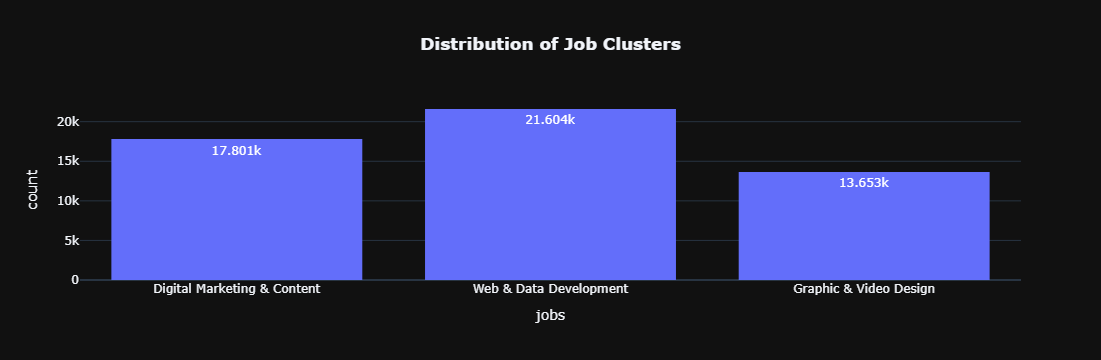

In [53]:
fig = px.histogram(data_frame=df , x = 'jobs' ,text_auto=True , 
                   title="<b> Distribution of Job Clusters </b>")
fig.update_layout(title_x=0.5)
fig.show()